## 프로젝트 주제
- 심부전 환자의 단기 사망 위험 예측에서 모델 성능(AUC)과 실제 임상 의사결정(threshold, 비용, calibration)은 어떻게 달라지는가?

### 문제 정의
- 심부전 환자의 사망 위험을 확률로 예측하고, 놓치면 치명적인 경우를 줄이는 방향으로 모델을 설계한다.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [5]:
# 데이터 로드
df = pd.read_csv("heart_failure.csv")

# 데이터 기본 확인
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### 데이터 구조 이해
- 모든 컬럼이 수치형
    - 트리 모델에 유리
- 결측치 없음
    - 전처리가 단순 (예상)
- 타깃 변수
    - DEATH_EVENT (0/1)

## 타깃 분포

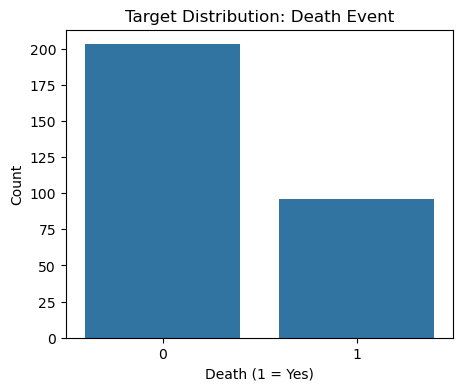

In [7]:
plt.figure(figsize=(5,4))
sns.countplot(x="DEATH_EVENT", data=df)
plt.title("Target Distribution: Death Event")
plt.xlabel("Death (1 = Yes)")
plt.ylabel("Count")
plt.show()


### 해석
- 사망 환자 비율이 낮음
    - 생존이 2배 정도 많아 보임
    - 데이터 불균형
        - 심각한 불균형은 아님
        - but 정확도는 쉽게 착시가 생길 수 있는 상황
        - 아무나 다 생존이라고 찍어도 정확도가 꽤 나옴.
- 모델 성능 평가를 할 때 Accuracy를 쓰면 위험
    - ROC-AUC, PR-AUC 같이 봐야 설득력 있을 것 (예상)
    - threshold 튜닝도 이 분포 때문에 필요할 것으로 예상

## 주요 임상 변수 분포

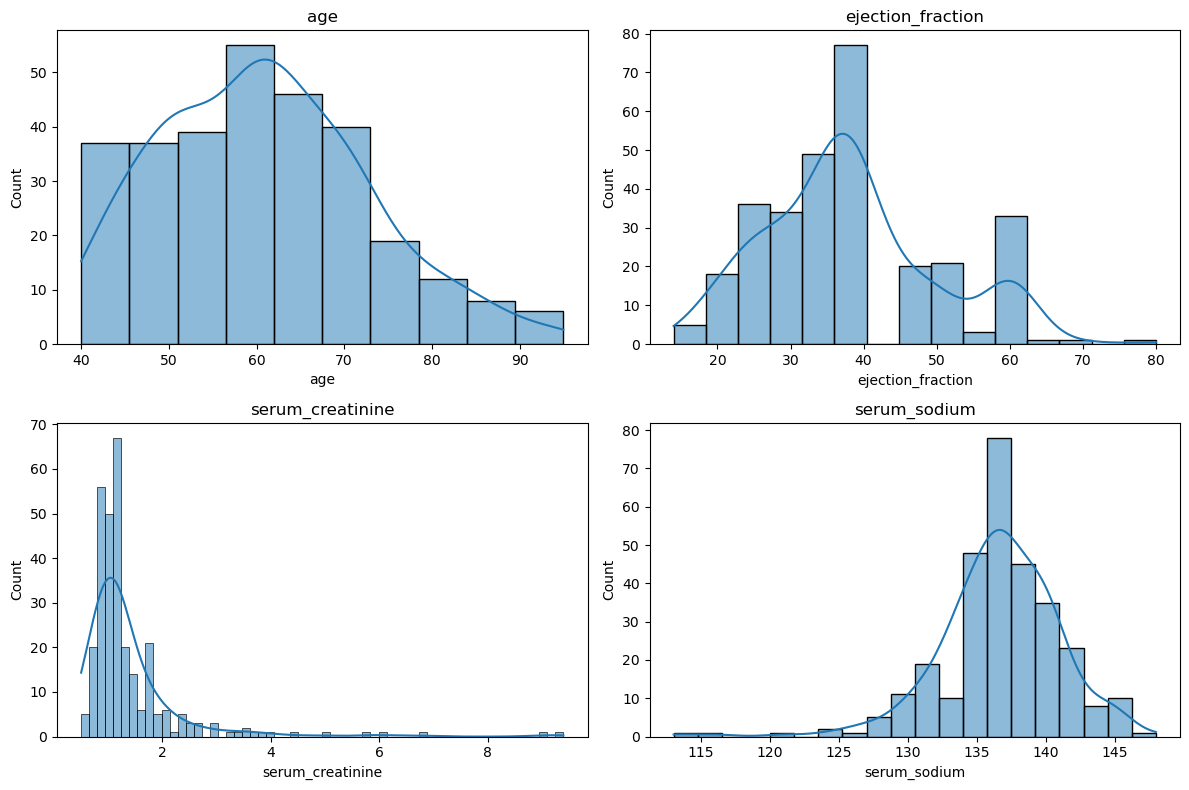

In [8]:
key_features = ["age", "ejection_fraction", "serum_creatinine", "serum_sodium"]

plt.figure(figsize=(12,8))
for i, col in enumerate(key_features, 1):
    plt.subplot(2,2,i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


### 해석
- age
    - 40 ~ 70대가 중심
    - 오른쪽으로 길게 늘어진 꼬리 (right-skewed)
- ejection fraction
    - 30 ~ 40 근처가 매우 많음
    - 60 근처에도 덩어리가 보임
        => 단일 매끈한 분포가 아님, 그룹이 섞인 느낌
        => 이런 덩어리 같은 구간의 특성들은 트리 모델이 꽤 잘 잡기 때문에 트리 모델 고려
- serum creatinine
    - 오른쪽 꼬리가 매우 김
    - outlier 많음
    - 대부분 1근처에 몰려 있음.
    => 비선형 변수
    => 선형 모델은 outlier에 민감해 질 수 있기 때문에
        => log 변환이나 robust 같은 스케일링을 고려해야함
    => 트리/XGB 쓰기 좋은 타입
- serum sodium
    - 비교적 정규 분포에 가까움
        - 135 ~ 140 근처가 중심이라 살짝 치우쳐진 left-skewed
    - 약간 낮은 값 쪽도 일부 있음

=================================================================
- log 보다는 트리나 XGB가 좋아 보임
- age나 serum sodium 같은 경우는 다른 변수들과 같이 있을 때의 경우를 고려 해 봐야 할 것 같음.

## 사망 여부에 따른 분포 차이

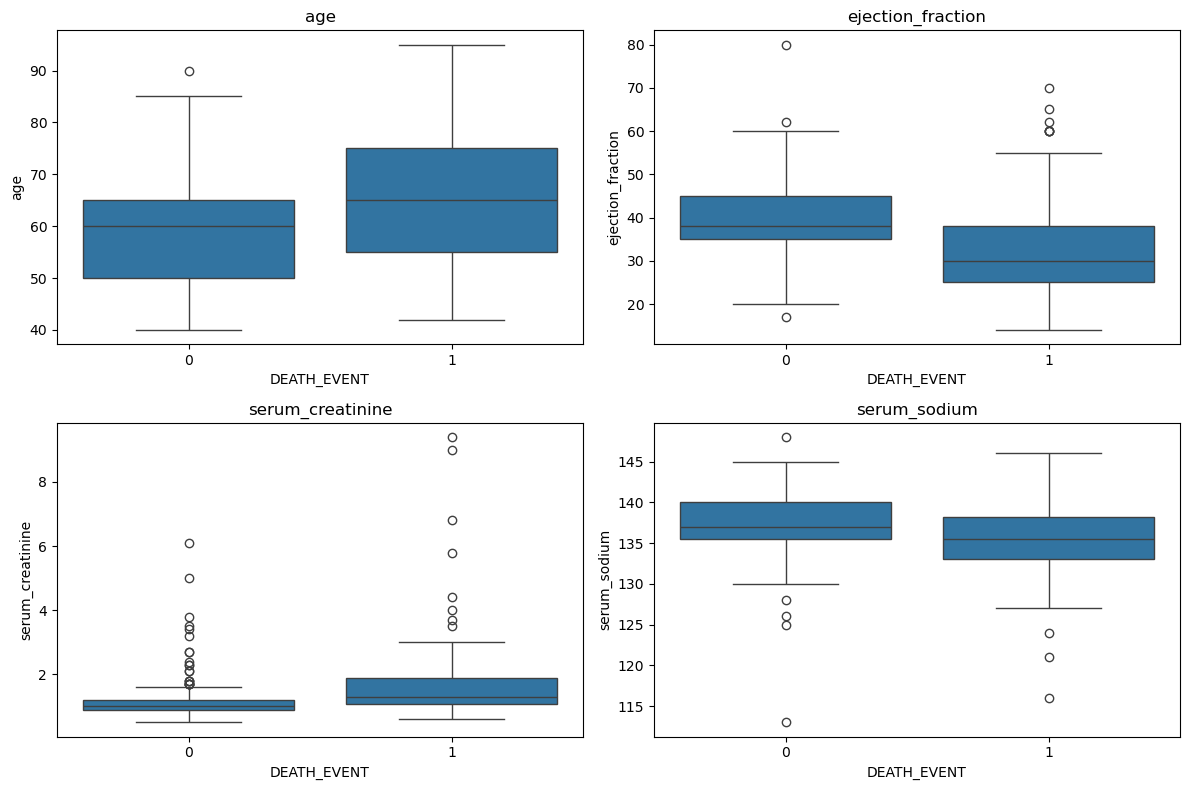

In [10]:
key_features = ["age", "ejection_fraction", "serum_creatinine", "serum_sodium"]

plt.figure(figsize=(12,8))
for i, col in enumerate(key_features, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x="DEATH_EVENT", y=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

### 해석
- age
    - 사망 그룹의 중앙값이 생존 그룹의 중앙값보다 높음
        - 나이가 많으면 사망 위험이 올라간다는 경향으로 볼 수 있음
            => 중요한 피처 후보
- ejection fraction
    - 사망 그룹이 ejection fraction이 낮음
        => 중요한 예측 변수일 가능성
        => 모델 해석 (importance/SHAP)에서 상위권이지 않을까?
- serum_creatinine
    - 사망 그룹이 중앙값이 더 높고, 극단치가 훨씬 많음.
        => 신장 기능이 악화하면 예후도 악화
        => 트리모델이 유리
        => 로지스틱으로 가려면 outlier 처리 전략.
- serum_sodium
    - 사망 그룹이 약간 낮아 보이긴 함.
    - but 차이가 앞에 그룹들 보다는 크지 않아 보임
        => 아마 단독으로 강력한 변수이진 않아도 트리 모델 같이 전체 모델에는 도움이 될 수 있는 변수라고 예상됨.


## 상관 구조

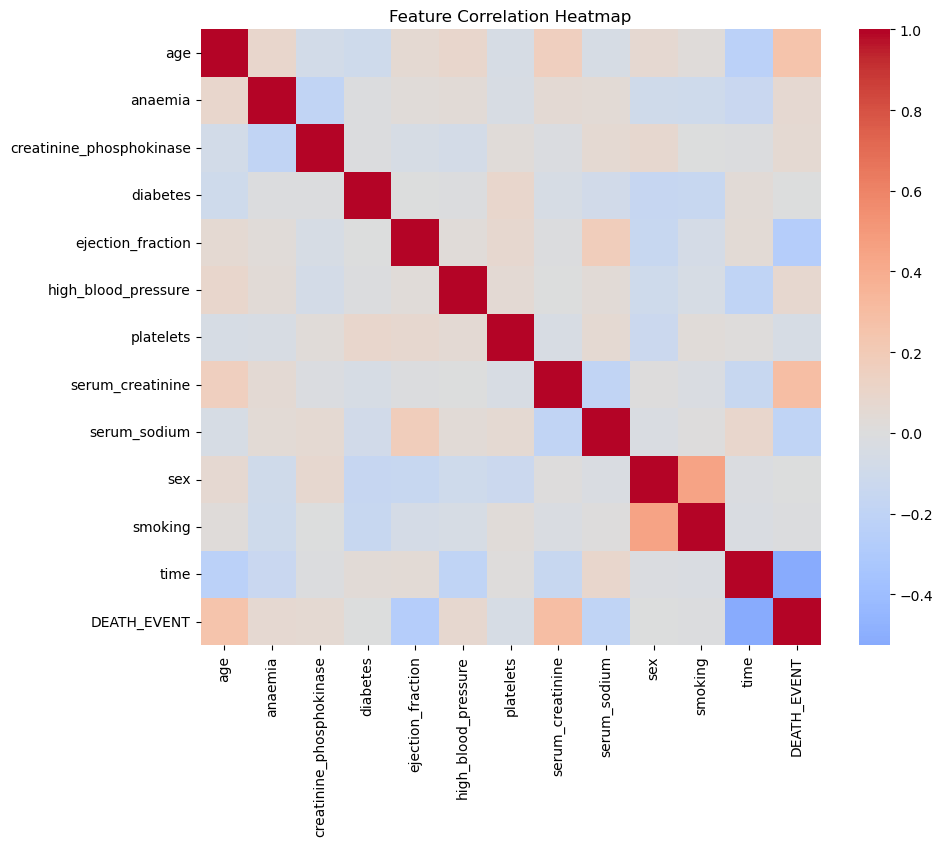

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### 해석
- 전체적으로 진한색이 거의 없음
    => 다중공선성이 심하지 않다.
    => 로지스틱 회귀도가 상관계수 때문에 망하는 케이스는 덜할 것으로 예상
        => but 비선형/임계값 효과가 더 중요해질 가능성이 큼
- DEATH_EVENT
    - time -> 사망과 음의 상관 꽤 강함
        => 사망한 사람은 관찰이 빨리 끝나고, 생존한 사람은 더 오래 관찰되는 구조
            => 사망과 time은 음의 상관이 강해지는게 자연스러움
            => "환자 상태(기본 검사)로 사망 위험을 예측" 하는 거라면
                => time은 미래를 반영한 정보라서 leakage 위험이 커짐
    - ejection_fraction -> 사망과 음의 상관
    - serum_creatinine -> 사망과 양의 상관
    - age -> 사망과 양의 상관
    - serum_sodium -> 사망과 약한 음의 상관
=================================================================
### 해석 결과 정리
- 모델을 2개의 버전으로 만들어 비교
    - time을 포함한 모델
        - 성능은 높게 나올 가능성
        - 생존 분석이라면 정확도(Score)를 최대한으로 낼수 있을 것임
    - time을 제외한 모델
        - 현실적인 임상 예측
        - 순수하게 의학적 징후로만 예측하고 싶다면 이 모델을 이용

## 통계 분석

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, chi2_contingency

df = pd.read_csv("heart_failure.csv")

target = "DEATH_EVENT"
num_cols = ["age", "creatinine_phosphokinase", "ejection_fraction",
            "platelets", "serum_creatinine", "serum_sodium", "time"]
bin_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]


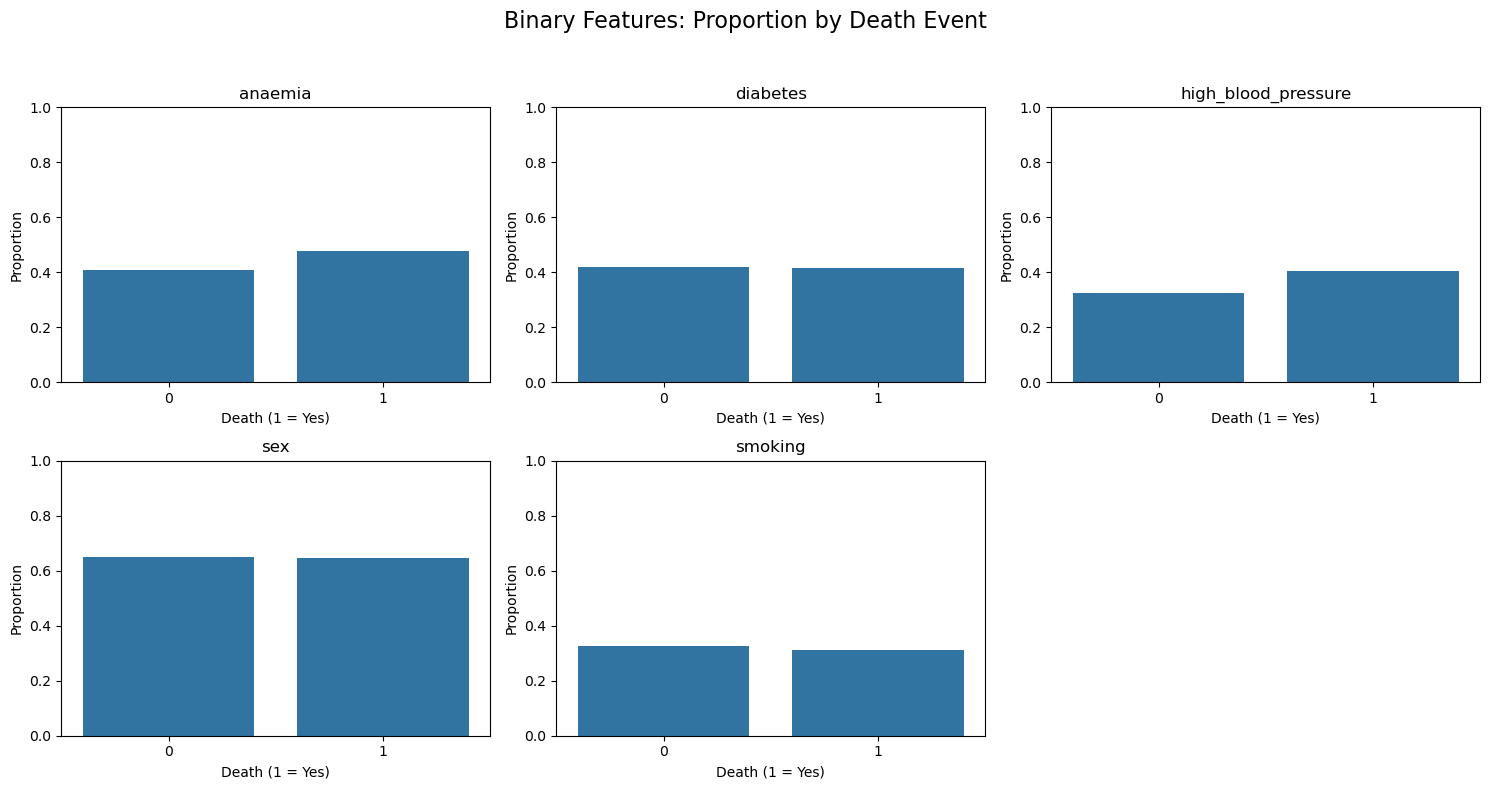

In [ ]:
# --------------------------------
# 1) 0/1 변수: 사망 여부별 비율 비교
# --------------------------------

# 0/1 변수 목록
bin_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

# figure 생성 (2행 3열 → 마지막 하나는 비워둠)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(bin_cols):
    rate = df.groupby("DEATH_EVENT")[col].mean().reset_index()

    sns.barplot(
        x="DEATH_EVENT",
        y=col,
        data=rate,
        ax=axes[i]
    )

    axes[i].set_title(col)
    axes[i].set_xlabel("Death (1 = Yes)")
    axes[i].set_ylabel("Proportion")
    axes[i].set_ylim(0, 1)

# 마지막 subplot(빈 칸) 제거
fig.delaxes(axes[-1])

plt.suptitle("Binary Features: Proportion by Death Event", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 해석
- 이진 변수들은 단독으로는 강한 예측력 없음
- but,
    - 임상적으로 의미 있는 배경 변수
    - 연속형 변수와 상호작용을 통해 간접적 기여 가능
        => 보조 정보로 유지

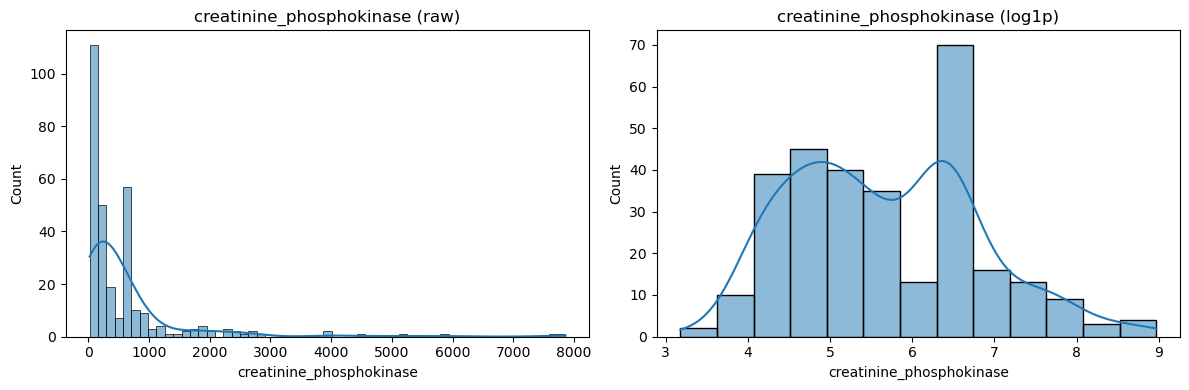

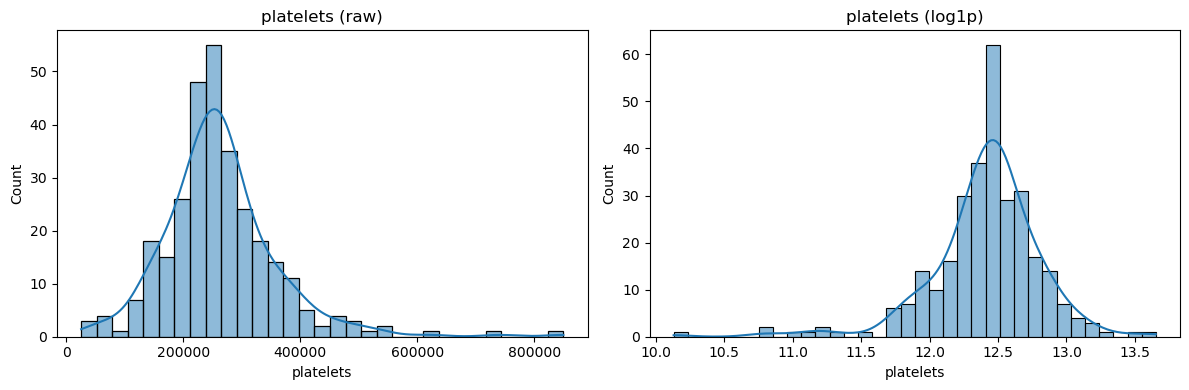

In [ ]:
# ----------------------------------------------
# 2) 긴 꼬리 변수(CPK, platelets) 분포 + 로그 분포
# ----------------------------------------------
skew_cols = ["creatinine_phosphokinase", "platelets"]

for col in skew_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # 원본 분포
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"{col} (raw)")

    # log1p 분포 (0 포함 가능 대비)
    sns.histplot(np.log1p(df[col]), kde=True, ax=axes[1])
    axes[1].set_title(f"{col} (log1p)")

    plt.tight_layout()
    plt.show()

### 해석
- CKP
    - right-skewed
    - 극단적으로 오른쪽 꼬리
    - log 처리 한 것이 분포가 훨씬 안정적임.
        - 다봉성 완화
            - 분포에 봉우리가 2개 이상 있는 형태
    - 로지스틱 회귀
        - raw 그대로 사용하면 계수 추정이 불안정
    - 트리/XGB
        - raw도 처리 가능하지만
        - log 변환 시 노이즈 감소 + 일반화 가능성 증가
=> 전처리
    - cpk는 log1p 변환 적용
    - 특히 time 제외 모델에서 중요하다고 생각함
        - 다른 강한 신호가 없어서.
        => time을 넣고 모델을 돌리면 거의 정답을 알려주는 것과 같은 강한 신호를 주는 변수이기 때문에 모델이 다른 변수들은 잘 생각하지 않을 가능성이 높음.
        => but, time을 넣게 되면, 예측 문제가 훨씬 어려워진 상태 인것이고, 모든 변수들을 사용해야 하기 때문에 노이즈 하나하나가 성능에 큰 영향을 주게 됨.
            => cpk 같은 분포가 불안정하고 이상치가 많은 변수를 그낭 raw로 넣게 되면
                - 로지스틱에서는 계수가 이상치에 끌려가서 전체 예측이 흔들릴 수 있고
                - 트리/XGB에서는 극단치 몇개 때문에 쓸데 없는 split이 생길 수 있음
                    - 일반화 성능이 하락할 위험이 있음
=============================================================================================
=> time이라는 ‘강력한 보호막’이 사라진 상황에서는 CPK를 얼마나 안정적으로 가공했는지가 모델 성능에 더 민감하게 작용할 가능성이 높다.

- platelets
    - raw
        - 상대적으로 덜 심하지만 여전히 right skewed
    - log1p
        - 거의 정규분포에 가까워짐
        - 왼쪽 꼬리가 있긴 하지만
    => 혈소판은 극단적으로 낮거나 높은 값이 임상적으로 의미 있을 수 있지만 이 데이터에서는 주요한 변수는 아닐 것이라 생각.
        => why? 사망군/생존군 중앙값 차이가 거의 없기 때문에
        => but, 다른 변수와 함께 있을 때 보정 역할은 할 수 있기 때문에 모델에는 사용. 
=> 전처리
    - log1p가 안정성 측면에서는 좋음
    - 예측력 자체에는 제한이 있을 듯
        => feature importance가 낮으면 과감히 해석에서는 비중을 낮추는 것이 좋을 듯

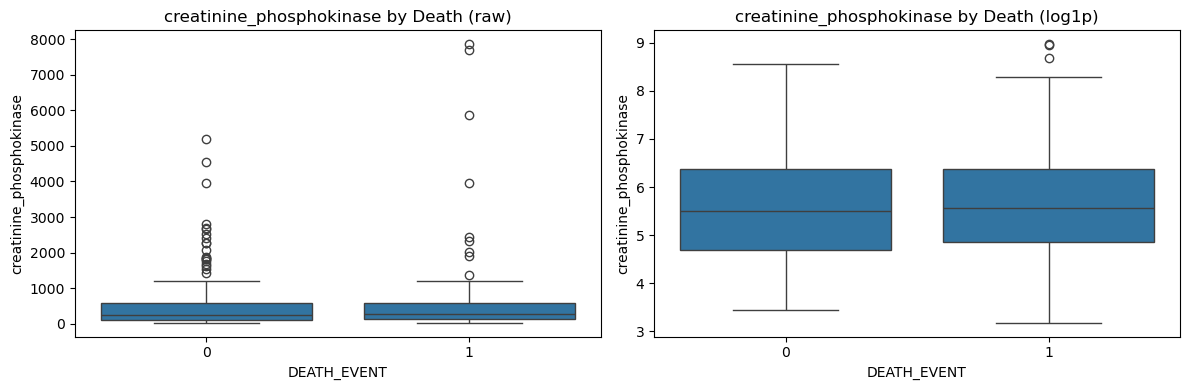

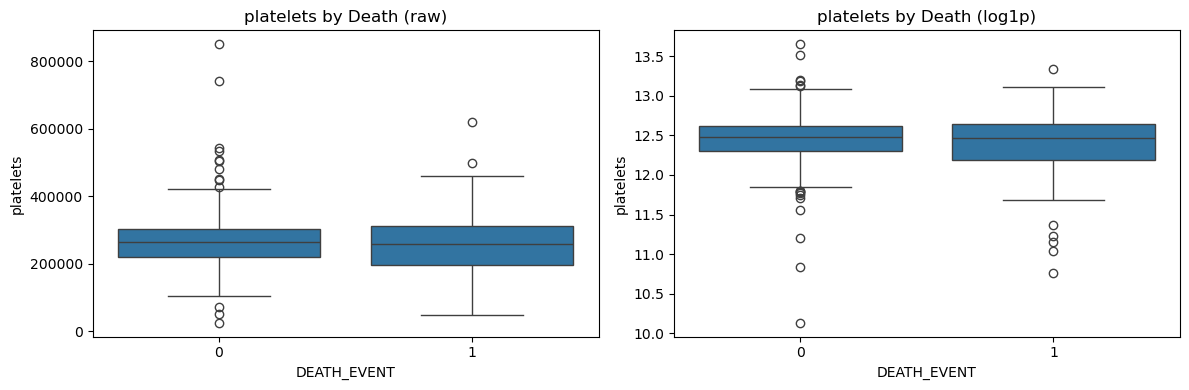

In [25]:
# ---------------------------------------
# 3) 사망 여부별 분포 비교 (로그 버전도 같이)
# ---------------------------------------
for col in skew_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.boxplot(x=target, y=col, data=df, ax=axes[0])
    axes[0].set_title(f"{col} by Death (raw)")

    sns.boxplot(x=target, y=np.log1p(df[col]), data=df, ax=axes[1])
    axes[1].set_title(f"{col} by Death (log1p)")

    plt.tight_layout()
    plt.show()

In [26]:
# -----------------------------
# 4) 연속형 변수: 사망군 vs 생존군 통계 검정 (Mann–Whitney)
#    * 이상치/비정규에 강함
# -----------------------------
stats_rows = []
for col in num_cols:
    g0 = df[df[target]==0][col]
    g1 = df[df[target]==1][col]

    # Mann–Whitney U test (양측)
    u, p = mannwhitneyu(g0, g1, alternative="two-sided")

    # 간단한 효과 크기 느낌: 중앙값 차이
    med0, med1 = np.median(g0), np.median(g1)

    stats_rows.append([col, med0, med1, p])

stats_df = pd.DataFrame(stats_rows, columns=["feature", "median_survive0", "median_death1", "p_value"])
stats_df = stats_df.sort_values("p_value")
print(stats_df)

                    feature  median_survive0  median_death1       p_value
6                      time            172.0           44.5  6.852197e-21
4          serum_creatinine              1.0            1.3  1.580998e-10
2         ejection_fraction             38.0           30.0  7.368249e-07
0                       age             60.0           65.0  1.667518e-04
5              serum_sodium            137.0          135.5  2.927557e-04
3                 platelets         263000.0       258500.0  4.255585e-01
1  creatinine_phosphokinase            245.0          259.0  6.840400e-01


### 해석
- time, EF, sc, age 가 핵심 변수일 것으로 보임.

In [27]:
# -----------------------------
# 5) 0/1 변수: 카이제곱 검정 + (간단) 오즈비 계산
# -----------------------------
def odds_ratio_2x2(a, b, c, d):
    # [[a,b],[c,d]] : a=death&1, b=death&0, c=survive&1, d=survive&0 형태로 맞춰서 계산
    # 0 나눗셈 방지용 0.5 보정(라플라스)
    a, b, c, d = a+0.5, b+0.5, c+0.5, d+0.5
    return (a*d) / (b*c)

or_rows = []
for col in bin_cols:
    tab = pd.crosstab(df[target], df[col])  # rows: death(0/1), cols: feature(0/1)
    chi2, p, _, _ = chi2_contingency(tab)

    # 오즈비 계산을 위해 형태 맞추기
    # death=1 행에서 col=1,0 / survive=0 행에서 col=1,0
    a = tab.loc[1,1] if (1 in tab.index and 1 in tab.columns) else 0
    b = tab.loc[1,0] if (1 in tab.index and 0 in tab.columns) else 0
    c = tab.loc[0,1] if (0 in tab.index and 1 in tab.columns) else 0
    d = tab.loc[0,0] if (0 in tab.index and 0 in tab.columns) else 0
    or_val = odds_ratio_2x2(a,b,c,d)

    or_rows.append([col, or_val, p])

or_df = pd.DataFrame(or_rows, columns=["feature", "odds_ratio(approx)", "p_value"]).sort_values("p_value")
print(or_df)

               feature  odds_ratio(approx)   p_value
2  high_blood_pressure            1.420399  0.214103
0              anaemia            1.328808  0.307316
4              smoking            0.948329  0.931765
1             diabetes            0.993479  1.000000
3                  sex            0.977577  1.000000


### 해석
- binary 변수들은 위험 요인이라기 보다는 환자 배경 설명용 변수라고 생각하면 될듯
    => Binary clinical indicators did not show significant standalone association with mortality, suggesting their role as contextual rather than primary predictive features.

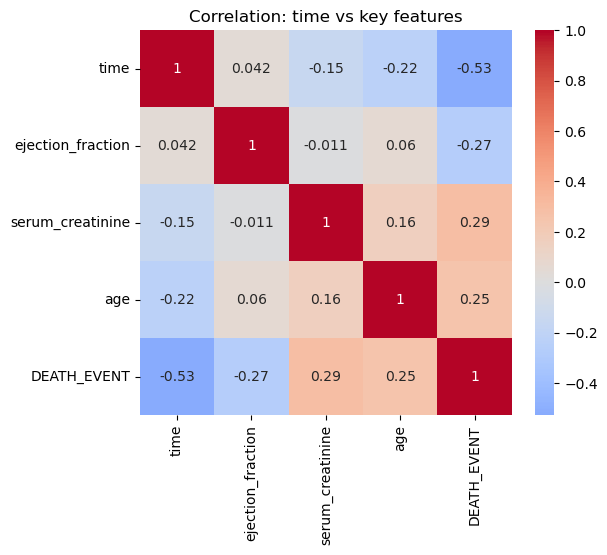

In [28]:
# -----------------------------
# 6) time과 주요 변수 관계 (time leakage 이해용)
# -----------------------------
focus = ["time", "ejection_fraction", "serum_creatinine", "age"]
plt.figure(figsize=(6,5))
sns.heatmap(df[focus + [target]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation: time vs key features")
plt.show()

### 해석
- time => 결과를 반영한 변수
    - 사망이 일어난 이후에야 확정되는 정보.
    - 성능이 폭발적으로 좋게 나올 가능성이 크지만, 현실 예측 시점에서는 알수 없는 정보
    - 환자가 병원에 왔을 때 지금 가진 검사 정보로 앞으로 사망 위험이 높은지를 예측하고 싶다.
        => 이것은 time을 포함한 모델로 환자가 앞으로 몇일을 더 살지 언제 사망할지 아무도 모름.
        => 결과를 암시하는 정보를 같이 준 셈이기 때문에 성능이 잘 나와서 모델이 똑똑해서가 아니라 답안 힌트를 같이 본 결과이기 때문에 데이터 누수가 생기는 것임. => 따라서 임상에서 배포가 불가능
            => 그래서 이럴 땐 생존 분석을 하는데,
                => "이 환자는 얼마나 오래 생존할까? 그리고 특정 시점까지 살아 있을 확률은 얼마 일까?"
                    => time + DEATH_EVENT를 세트로 타깃으로 보는 것
                        => 이러면 time을 미래 정보로 보는 것이 아니라 관찰 결과의 일부로 보는 것.
- time을 제외한 모델이 훨씬 더 어려운 예측 문제들을 풀기 때문에 score나 성능이 잘 나오지 않을 수는 있지만
    - 실제 임상 배포가 가능 할 것.

## 전처리

In [31]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 28.0 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 30.0 MB/s  0:00:10m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost (설치되어 있어야 함)
from xgboost import XGBClassifier

In [33]:
# =========================================================
# 0) Load data
# =========================================================
df = pd.read_csv("heart_failure.csv")

TARGET = "DEATH_EVENT"
DROP_COLS = ["time"]  # ✅ time 제외

X = df.drop(columns=[TARGET] + DROP_COLS)
y = df[TARGET]

# (선택) 컬럼 목록 확인
print("Features:", list(X.columns))
print("Target distribution:\n", y.value_counts(normalize=True))

Features: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']
Target distribution:
 DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64


In [34]:
# =========================================================
# 1) Train/Test split (stratify로 클래스 비율 유지)
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [35]:
# =========================================================
# 2) Feature groups (전처리 정책)
#    - log1p: 긴 꼬리 변수 안정화
#    - 나머지 수치형: 결측 처리만
#    - 이진형: 결측 처리만 (이미 0/1이므로)
# =========================================================
log_cols = ["creatinine_phosphokinase", "platelets"]  # ✅ log1p 적용 권장
bin_cols = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
# 나머지 수치형 컬럼 자동 추출
num_cols = [c for c in X.columns if c not in (log_cols + bin_cols)]

print("log_cols:", log_cols)
print("num_cols:", num_cols)
print("bin_cols:", bin_cols)

log_cols: ['creatinine_phosphokinase', 'platelets']
num_cols: ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
bin_cols: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']


In [36]:
# =========================================================
# 3) 공통 전처리 블록 만들기
#    - log_cols: 결측치 처리 -> log1p 변환 -> (로지스틱에선 스케일링 필요)
#    - num_cols: 결측치 처리 -> (로지스틱에선 스케일링 필요)
#    - bin_cols: 결측치 처리 (most_frequent)
# =========================================================

def log1p_transform(X_array):
    """ColumnTransformer에서 사용: numpy array에 log1p 적용"""
    return np.log1p(X_array)

from sklearn.preprocessing import FunctionTransformer
log1p = FunctionTransformer(log1p_transform, feature_names_out="one-to-one")

# --- (A) Logistic 전용 전처리: 수치형 스케일링 포함 ---
logistic_preprocess = ColumnTransformer(
    transformers=[
        # log 변수: impute -> log1p -> scale
        ("log", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("log1p", log1p),
            ("scaler", StandardScaler())
        ]), log_cols),

        # 일반 수치형: impute -> scale
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),

        # 이진형: impute만 (스케일링 불필요)
        ("bin", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), bin_cols),
    ],
    remainder="drop"
)

# --- (B) Tree/XGB 전용 전처리: 스케일링 없이 log1p만 적용 ---
tree_preprocess = ColumnTransformer(
    transformers=[
        # log 변수: impute -> log1p
        ("log", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("log1p", log1p)
        ]), log_cols),

        # 일반 수치형: impute만
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),

        # 이진형: impute만
        ("bin", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), bin_cols),
    ],
    remainder="drop"
)

# =========================================================
# 4 모델별 파이프라인 구성
# =========================================================

In [37]:
# 4-1) Logistic Regression (baseline)
log_clf = Pipeline(steps=[
    ("preprocess", logistic_preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",   # 불균형 대응(가볍게)
        random_state=42
    ))
])

In [100]:
# 4-2) Random Forest
rf_clf = Pipeline(steps=[
    ("preprocess", tree_preprocess),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

In [38]:
# 4-3) XGBoost
xgb_clf = Pipeline(steps=[
    ("preprocess", tree_preprocess),
    ("model", XGBClassifier(
        n_estimators=600,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        # 불균형 대응: scale_pos_weight는 학습 데이터 기준으로 계산 추천
        # 일단 자동 계산해 넣고 싶으면 아래처럼:
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    ))
])

In [102]:
# =========================================================
# 5) 전처리/파이프라인이 제대로 도는지 빠른 체크용 학습 & 평가
# =========================================================
models = {
    "Logistic (baseline)": log_clf,
    "RandomForest": rf_clf,
    "XGBoost": xgb_clf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)

    print(f"\n[{name}]")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC : {pr:.4f}")



[Logistic (baseline)]
ROC-AUC: 0.7381
PR-AUC : 0.5934

[RandomForest]
ROC-AUC: 0.8036
PR-AUC : 0.6127

[XGBoost]
ROC-AUC: 0.7754
PR-AUC : 0.5560


## 모델 성능 평가

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

thresholds = [0.5, 0.4, 0.3, 0.2]

models = {
    "Logistic": log_clf,
    "RandomForest": rf_clf,
    "XGBoost": xgb_clf
}

proba_dict = {}

for name, model in models.items():
    # 혹시 fit 안 했으면 fit
    model.fit(X_train, y_train)

    # test에서 확률 예측
    proba = model.predict_proba(X_test)[:, 1]
    proba_dict[name] = proba


In [71]:
from sklearn.metrics import(
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

In [72]:
for name, model in models.items():
    print("=" * 80)
    print(f"MODEL: {name}")
    print("=" * 80)

    # 혹시 fit 안 되어 있으면
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    for thr in thresholds:
        y_pred = (proba >= thr).astype(int)

        print("-" * 60)
        print(f"Threshold = {thr}")
        print("-" * 60)

        # 👉 네가 원한 바로 그 출력
        print(classification_report(
            y_test,
            y_pred,
            digits=2,
            zero_division=0
        ))

MODEL: Logistic
------------------------------------------------------------
Threshold = 0.5
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        41
           1       0.53      0.53      0.53        19

    accuracy                           0.70        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.70      0.70      0.70        60

------------------------------------------------------------
Threshold = 0.4
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        41
           1       0.54      0.74      0.62        19

    accuracy                           0.72        60
   macro avg       0.70      0.72      0.70        60
weighted avg       0.75      0.72      0.73        60

------------------------------------------------------

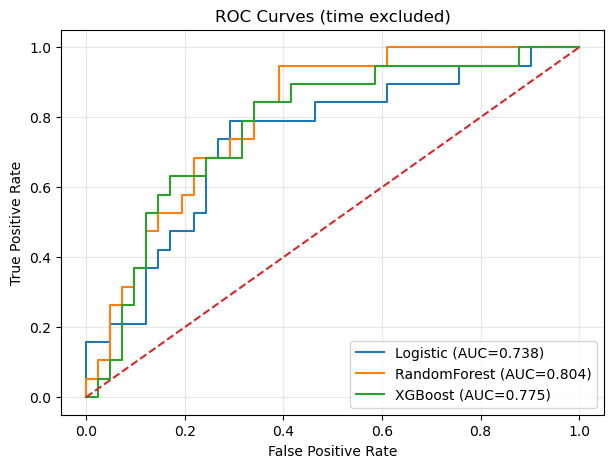

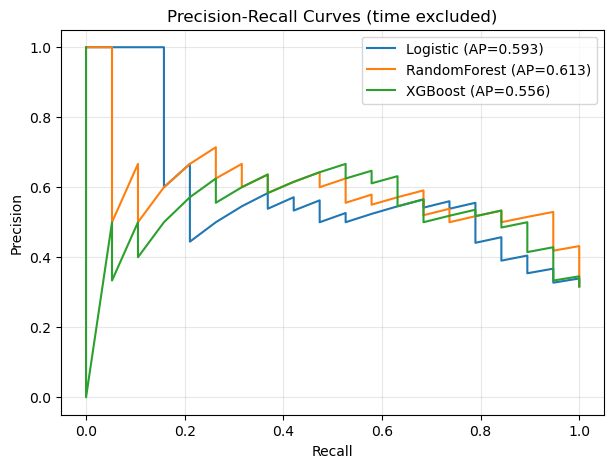

In [73]:
# -----------------------------
# 1) 확률 예측 준비
# -----------------------------
proba_dict = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # 혹시 fit 안 했으면
    proba_dict[name] = model.predict_proba(X_test)[:, 1]

# -----------------------------
# 2) ROC Curve (AUC 포함)
# -----------------------------
plt.figure(figsize=(7, 5))

for name, proba in proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (time excluded)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# -----------------------------
# 3) Precision-Recall Curve (AP = PR-AUC 포함)
# -----------------------------
plt.figure(figsize=(7, 5))

for name, proba in proba_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)   # PR-AUC (Average Precision)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (time excluded)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

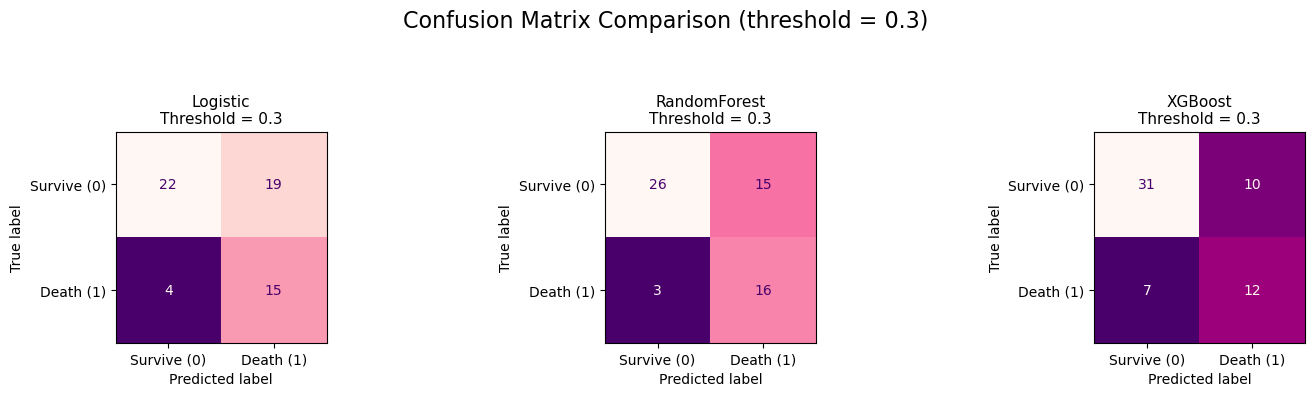

In [75]:
thr = 0.3

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, proba) in zip(axes, proba_dict.items()):
    y_pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Survive (0)", "Death (1)"]
    )

    disp.plot(
        ax=ax,
        cmap='RdPu_r',
        values_format="d",
        colorbar=False
    )

    ax.set_title(f"{name}\nThreshold = {thr}", fontsize=11)
    ax.grid(False)

plt.suptitle("Confusion Matrix Comparison (threshold = 0.3)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


## Calibration curve + Platt(sigmoid)/Isotonic 보정

In [76]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

In [77]:
def plot_calibration_curves(model_name, fitted_model, platt_model, isotonic_model, X_test, y_test, n_bins=10):
    """원본 vs Platt(sigmoid) vs Isotonic calibration curve를 한 plot에"""
    plt.figure(figsize=(7, 5))

    for label, mdl in [
        ("Original", fitted_model),
        ("Platt (sigmoid)", platt_model),
        ("Isotonic", isotonic_model),
    ]:
        proba = mdl.predict_proba(X_test)[:, 1]
        frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=n_bins, strategy="quantile")
        brier = brier_score_loss(y_test, proba)

        plt.plot(mean_pred, frac_pos, marker="o", label=f"{label} (Brier={brier:.3f})")

    # 완벽한 calibration 기준선
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"Calibration Curves - {model_name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


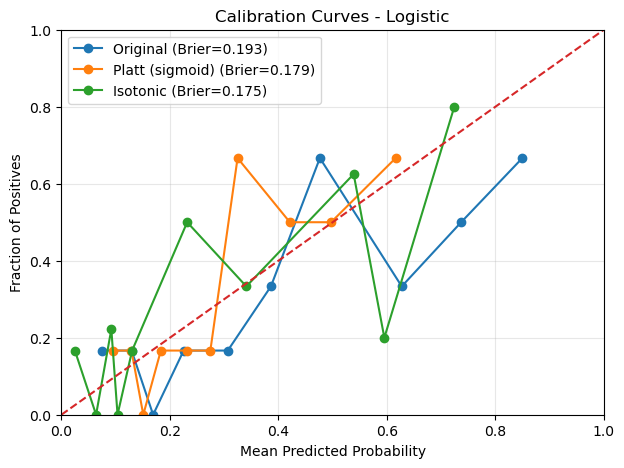

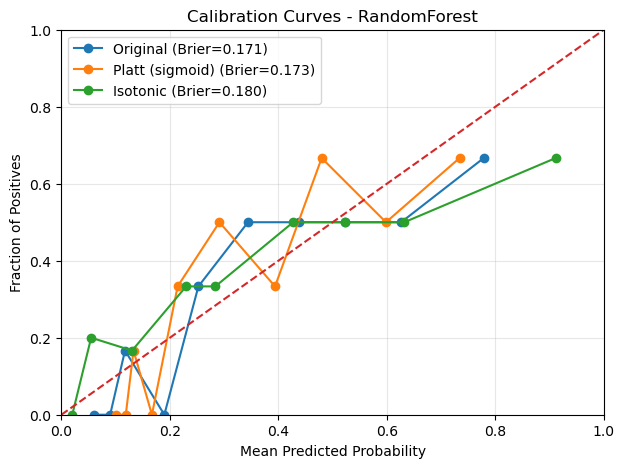

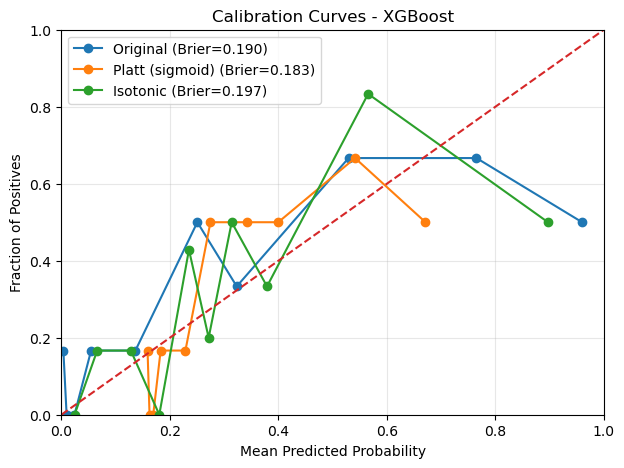

In [78]:
calibrated_models = {}

for name, base_model in models.items():
    # base_model은 이미 fit 되어있다고 가정 (위에서 fit 했음)
    # calibration은 training 데이터로 다시 CV 학습하는 게 정석이라 여기서 진행

    platt = CalibratedClassifierCV(base_model, method="sigmoid", cv=5)
    isotonic = CalibratedClassifierCV(base_model, method="isotonic", cv=5)

    platt.fit(X_train, y_train)
    isotonic.fit(X_train, y_train)

    calibrated_models[name] = {
        "original": base_model,
        "platt": platt,
        "isotonic": isotonic
    }

    plot_calibration_curves(
        model_name=name,
        fitted_model=base_model,
        platt_model=platt,
        isotonic_model=isotonic,
        X_test=X_test,
        y_test=y_test,
        n_bins=10
    )


In [79]:
!pip install lifelines

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4119 sha256=645b842f4fee265554fcba3a1a370e63859863685f88cf5eead4386f7600043f
  Stored in directory: /home/moonyj00/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [lifelines]/7 [formulaic]


In [80]:
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 15.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-survival] [scikit-survival]


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# ---------------------------------------------------
# Load
# ---------------------------------------------------
df = pd.read_csv("heart_failure.csv")

DURATION = "time"         # 생존시간
EVENT = "DEATH_EVENT"     # 사건(사망) 여부: 1=death, 0=survive

# 생존분석에서 feature는 time을 제외하고 사용(= time은 y에 들어감)
X = df.drop(columns=[EVENT, DURATION])
y_event = df[EVENT].astype(int)
y_time = df[DURATION].astype(float)

# Stratify는 event 기준이 현실적으로 가장 안전
X_train, X_test, y_event_train, y_event_test, y_time_train, y_time_test = train_test_split(
    X, y_event, y_time, test_size=0.2, random_state=42, stratify=y_event
)

# KM curve (전체 생존곡선) - lifelines가 있으면 아래에서 그림
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Event rate train:", y_event_train.mean(), "test:", y_event_test.mean())


Train size: (239, 11) Test size: (60, 11)
Event rate train: 0.32217573221757323 test: 0.31666666666666665


In [86]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [87]:
# ---------------------------------------------------
# CoxPH 입력 데이터 만들기 (train/test)
# ---------------------------------------------------
train_cox = X_train.copy()
train_cox[DURATION] = y_time_train.values
train_cox[EVENT] = y_event_train.values

test_cox = X_test.copy()
test_cox[DURATION] = y_time_test.values
test_cox[EVENT] = y_event_test.values

In [91]:
# ---------------------------------------------------
# 1) Cox 모델 학습
# ---------------------------------------------------
cph = CoxPHFitter(penalizer=0.01)  # 작은 L2 규제(안정화)
cph.fit(train_cox, duration_col=DURATION, event_col=EVENT)

print("\n[CoxPH Summary]")
print(cph.summary.sort_values("p"))


[CoxPH Summary]
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
serum_creatinine          0.335      1.397     0.072           0.193   
ejection_fraction        -0.050      0.952     0.011          -0.072   
age                       0.038      1.039     0.011           0.017   
creatinine_phosphokinase  0.000      1.000     0.000           0.000   
high_blood_pressure       0.502      1.651     0.235           0.040   
anaemia                   0.480      1.616     0.239           0.011   
diabetes                  0.386      1.471     0.249          -0.103   
serum_sodium             -0.030      0.970     0.025          -0.080   
smoking                   0.301      1.351     0.273          -0.233   
sex                      -0.172      0.842     0.277          -0.716   
platelets                -0.000      1.000     0.000          -0.000   

                          coef upper 95%  exp(

In [92]:
# ---------------------------------------------------
# 2) C-index 평가 (risk score = partial hazard)
# ---------------------------------------------------
# Cox는 “risk score가 높을수록 더 위험” (생존시간 짧음)
risk_test = cph.predict_partial_hazard(test_cox).values.ravel()
cindex = concordance_index(y_time_test, -risk_test, y_event_test)  
# lifelines concordance_index는 "예측값이 클수록 생존시간이 커진다" 방향에 민감해서 -risk 사용

print(f"\n[CoxPH] Test C-index: {cindex:.3f}")


[CoxPH] Test C-index: 0.724



[PH Assumption Check]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 239 total observations, 162 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic      p  -log2(p)
age                      km              0.16   0.69      0.54
                         rank            0.08   0.78      0.35
anaemia                  km              0.07   0.79      0.35
                         rank            0.06   0.81      0.30
creatinine_phosphokinase km              0.65   0.42      1.25
                         rank            0.73   0.39      1.34
diabetes                 km              0.48   0.49      1.03
                         rank            0.86   0.35      1.50
ejection_fraction        km              8.30 <0.005      7.98
                         rank            8.91 <0.005      8.46
high_blood_pressure      km              0.12   0.73      0.46
                         rank            0.05   0.82      0.29
platelets                km              0.11   0.74      0.44
                         rank            0.22   0.64      0.64
serum_creatinine         km              5.64   0.02      5.83
                         rank            5.58   0.02      5.78
serum_sodium             km              3.29   0.07      3.84
                         rank            3.88   0.05      4.36
sex                      km              0.01   0.92      0.12
                         rank            0.07   0.79      0.35
smoking                  km              0.00   1.00      0.01
                         rank            0.02   0.89      0.16



1. Variable 'ejection_fraction' failed the non-proportional test: p-value is 0.0028.

   Advice 1: the functional form of the variable 'ejection_fraction' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ejection_fraction' using pd.cut, and then specify it in
`strata=['ejection_fraction', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'serum_creatinine' failed the non-proportional test: p-value is 0.0176.

   Advice 1: the functional form of the variable 'serum_creatinine' mig

[[<Axes: xlabel='rank-transformed time\n(p=0.7833)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6863)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8124)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7859)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3941)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4200)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3535)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4889)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0028)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0040)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8175)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7277)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6413)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7364)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0182)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0176)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0487)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0698)'>],
 [<Axes: xlabel='rank-transformed tim

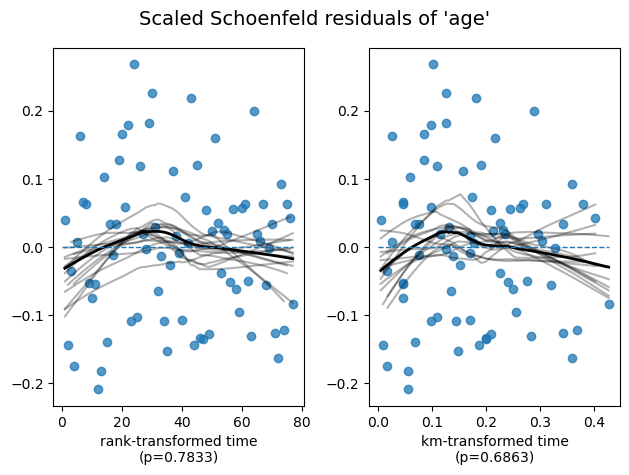

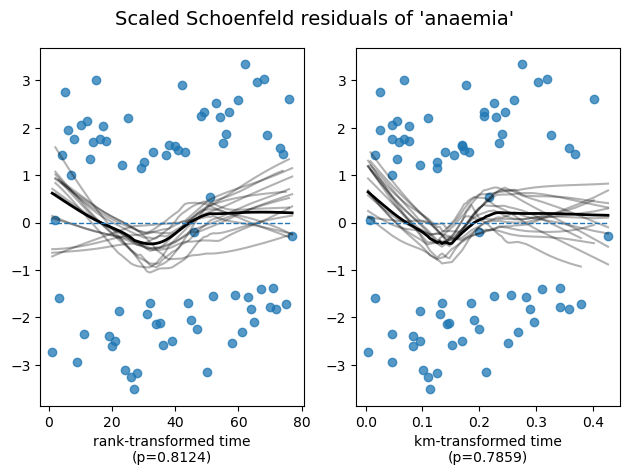

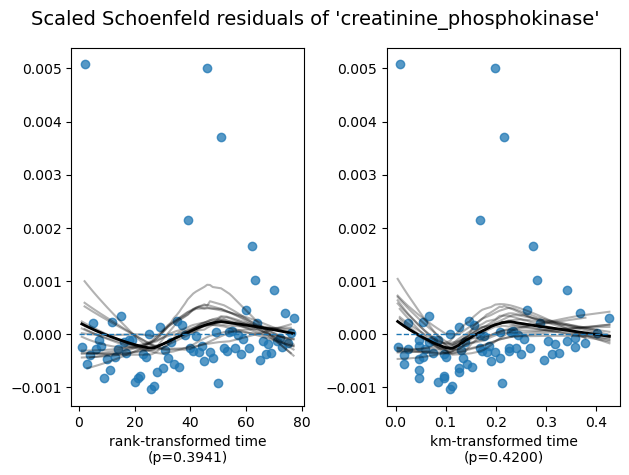

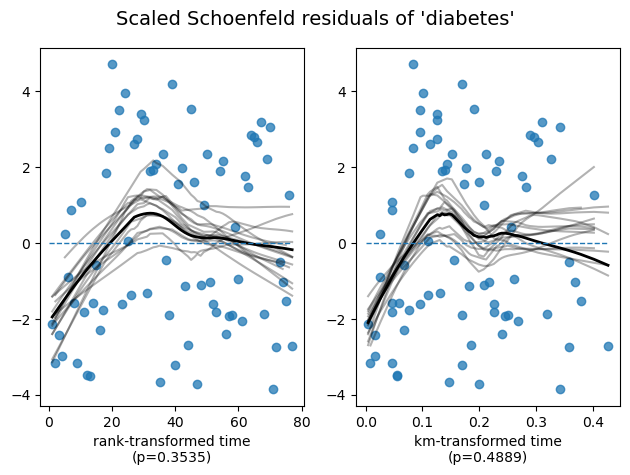

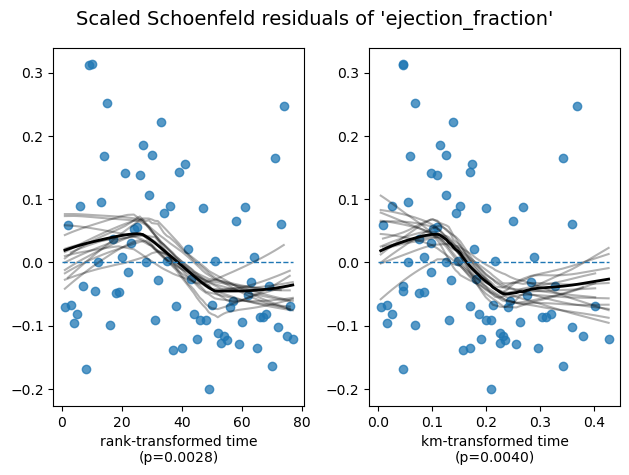

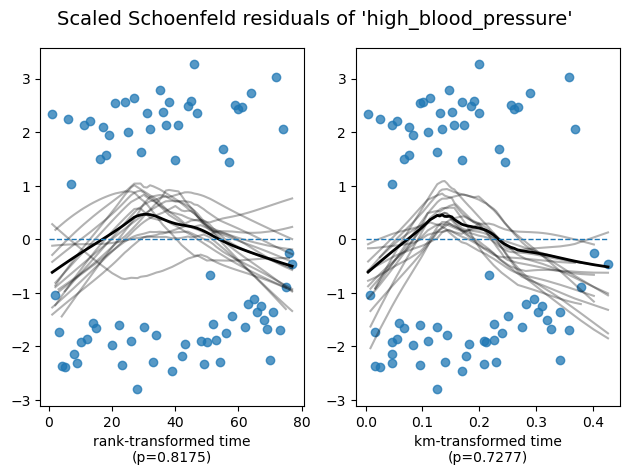

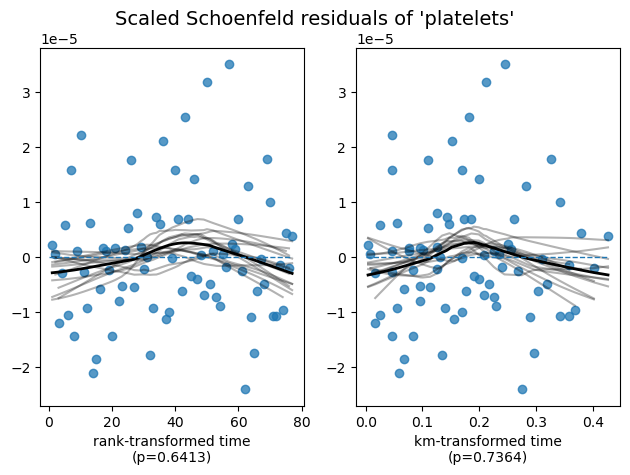

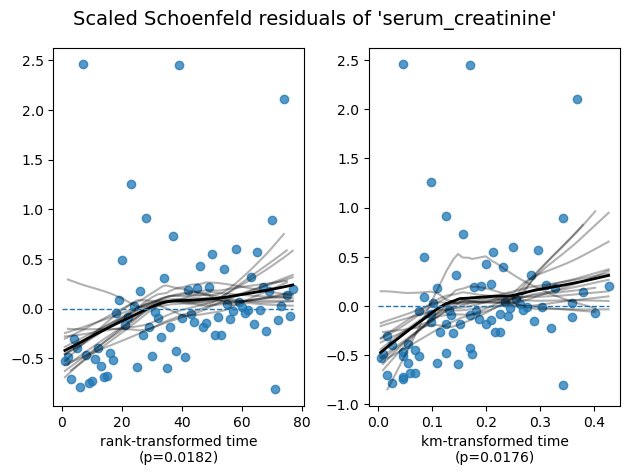

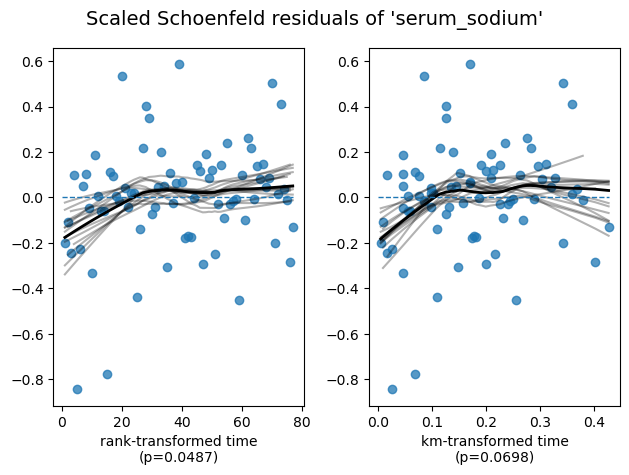

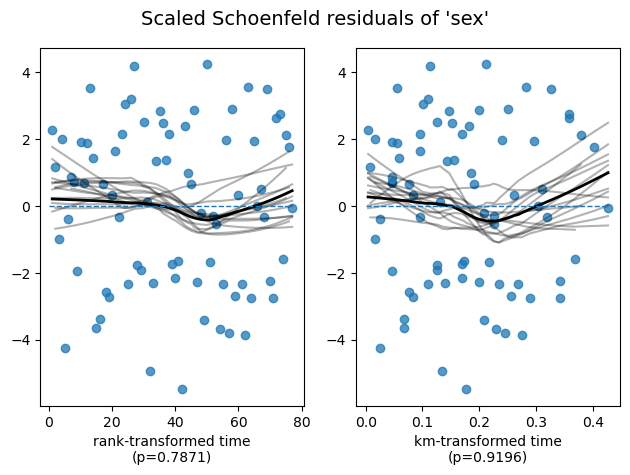

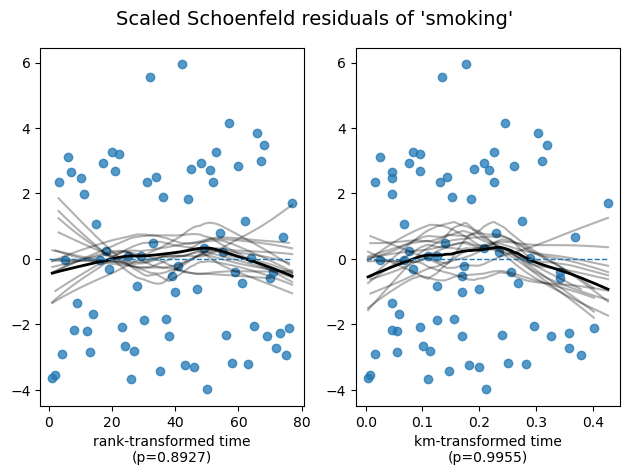

In [93]:
# ---------------------------------------------------
# 3) PH 가정 검정 (전공자 포인트)
#    - 위반 변수/패턴을 리포트로 출력
# ---------------------------------------------------
print("\n[PH Assumption Check]")
cph.check_assumptions(train_cox, p_value_threshold=0.05, show_plots=True)

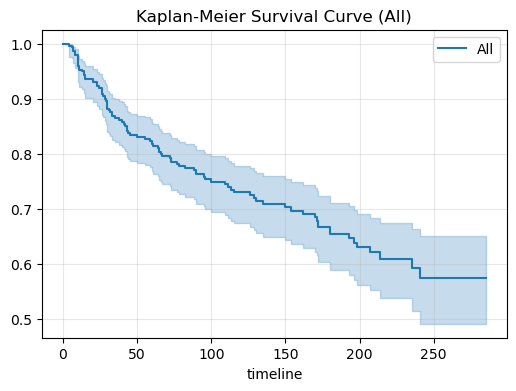

In [94]:
# ---------------------------------------------------
# 4) KM curve (전체 / 그룹 비교 예시)
# ---------------------------------------------------
kmf = KaplanMeierFitter()

plt.figure(figsize=(6,4))
kmf.fit(durations=df[DURATION], event_observed=df[EVENT], label="All")
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve (All)")
plt.grid(True, alpha=0.3)
plt.show()

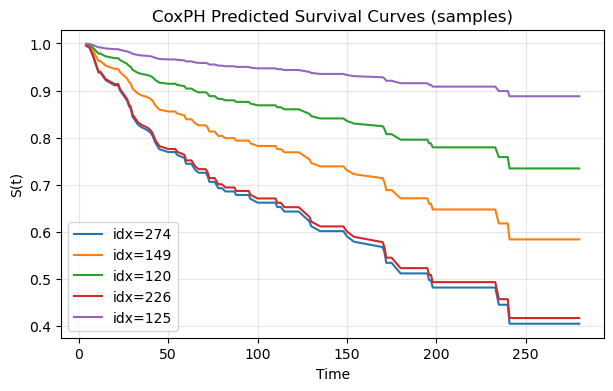

In [95]:
# ---------------------------------------------------
# 5) 예측 생존곡선: 테스트 샘플 몇 개 찍어보기
# ---------------------------------------------------
sample_idx = X_test.index[:5]
surv_funcs = cph.predict_survival_function(test_cox.loc[sample_idx])

plt.figure(figsize=(7,4))
for col in surv_funcs.columns:
    plt.plot(surv_funcs.index, surv_funcs[col], label=f"idx={col}")
plt.title("CoxPH Predicted Survival Curves (samples)")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


[RSF] Test C-index: 0.744


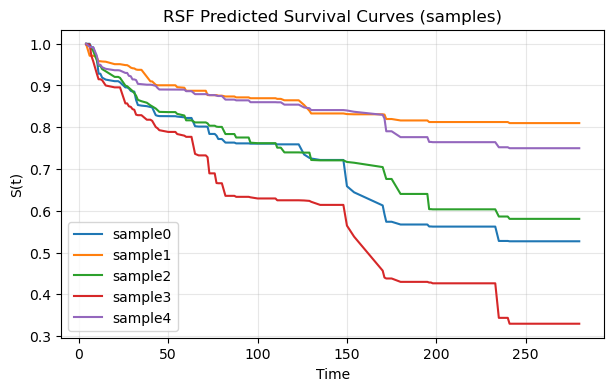

In [83]:
# scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# ---------------------------------------------------
# y를 생존분석용 구조화 배열로 변환
# ---------------------------------------------------
y_train_s = Surv.from_arrays(event=y_event_train.astype(bool), time=y_time_train)
y_test_s  = Surv.from_arrays(event=y_event_test.astype(bool),  time=y_time_test)

# ---------------------------------------------------
# RSF 학습
# ---------------------------------------------------
rsf = RandomSurvivalForest(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train_s)

# ---------------------------------------------------
# C-index (censored concordance)
# ---------------------------------------------------
pred_risk = rsf.predict(X_test)  # risk score 비슷하게 사용 가능(높을수록 위험)
cindex_rsf = concordance_index_censored(y_test_s["event"], y_test_s["time"], pred_risk)[0]
print(f"\n[RSF] Test C-index: {cindex_rsf:.3f}")

# ---------------------------------------------------
# 예측 생존곡선 (몇 샘플)
# ---------------------------------------------------
surv_fns = rsf.predict_survival_function(X_test.iloc[:5], return_array=False)

plt.figure(figsize=(7,4))
for i, fn in enumerate(surv_fns):
    plt.plot(fn.x, fn.y, label=f"sample{i}")
plt.title("RSF Predicted Survival Curves (samples)")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



[XGB survival:cox] Test C-index: 0.571


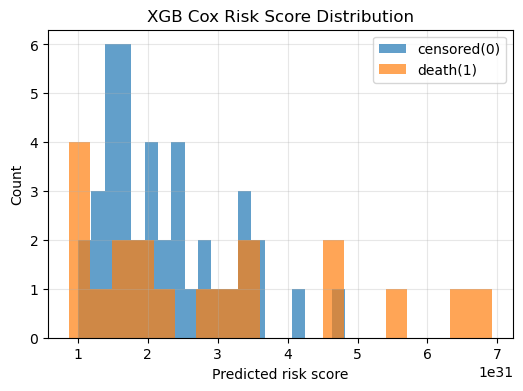

In [84]:
from xgboost import XGBRegressor
from lifelines.utils import concordance_index

# ---------------------------------------------------
# XGB Cox는 label = time, sample_weight = event(사망=1, 검열=0) 관례로 많이 사용
# (Cox partial likelihood에서 censor가 weight처럼 반영됨)
# ---------------------------------------------------
xgb_cox = XGBRegressor(
    objective="survival:cox",
    n_estimators=800,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb_cox.fit(
    X_train, y_time_train,
    sample_weight=y_event_train  # event=1만 loss에 강하게 반영
)

# ---------------------------------------------------
# risk score 예측 및 C-index
# ---------------------------------------------------
risk_xgb = xgb_cox.predict(X_test)  # 값이 클수록 위험(대체로)
cindex_xgb = concordance_index(y_time_test, -risk_xgb, y_event_test)
print(f"\n[XGB survival:cox] Test C-index: {cindex_xgb:.3f}")

# ---------------------------------------------------
# 위험도 분포 시각화(대시보드용)
# ---------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(risk_xgb[y_event_test==0], bins=20, alpha=0.7, label="censored(0)")
plt.hist(risk_xgb[y_event_test==1], bins=20, alpha=0.7, label="death(1)")
plt.title("XGB Cox Risk Score Distribution")
plt.xlabel("Predicted risk score")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [85]:
results = pd.DataFrame({
    "model": ["CoxPH", "RSF", "XGB survival:cox"],
    "c_index": [cindex, cindex_rsf, cindex_xgb]
}).sort_values("c_index", ascending=False)

print("\n=== Survival Model Comparison (C-index) ===")
print(results)



=== Survival Model Comparison (C-index) ===
              model  c_index
1               RSF    0.744
0             CoxPH    0.724
2  XGB survival:cox    0.571


In [98]:
# 필요시 설치
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 32.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


PermutationExplainer explainer: 61it [03:45,  3.82s/it]                        


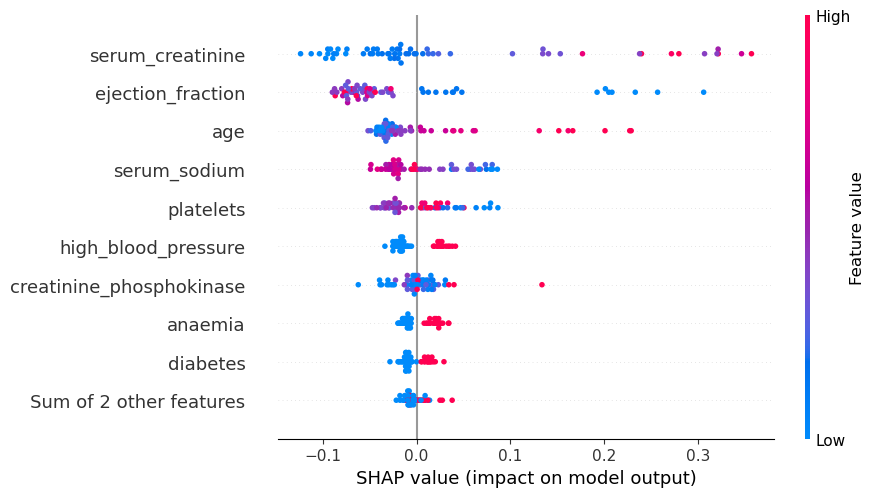

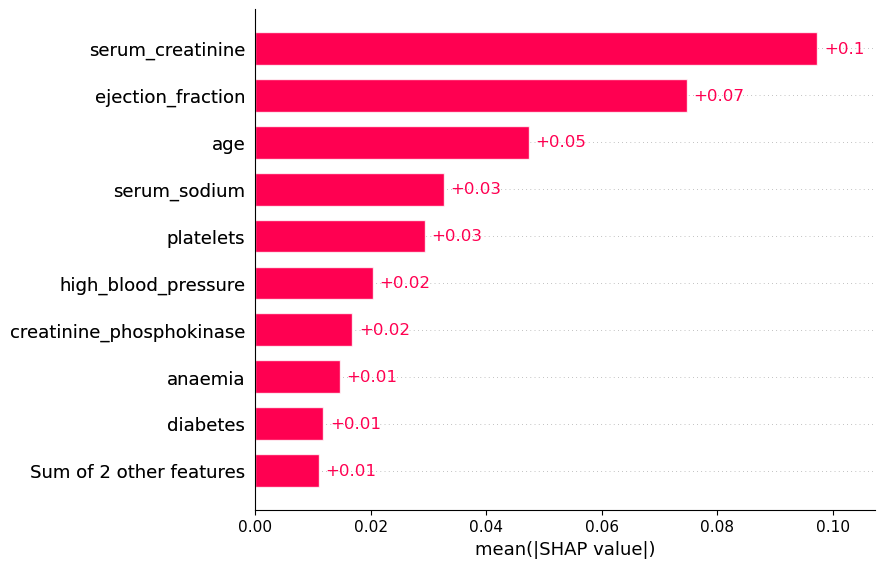

In [104]:
import shap
import numpy as np

# Pipeline 전체를 예측 함수로 감싸기
f = lambda X: rf_clf.predict_proba(X)[:, 1]   # death=1 확률

# background는 보통 train 일부 샘플 (너무 크면 느려짐)
background = X_train.sample(100, random_state=42)

explainer = shap.Explainer(f, background)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)             # 전체 요약
shap.plots.bar(shap_values)                  # 전역 중요도


In [107]:
# cph: lifelines.CoxPHFitter
cox_sum = cph.summary.copy()

# 영향 크기(절대값)로 정렬
cox_sum["abs_coef"] = cox_sum["coef"].abs()
cox_sum_sorted = cox_sum.sort_values("abs_coef", ascending=False)

display_cols = ["coef", "exp(coef)", "p", "abs_coef"]
print(cox_sum_sorted[display_cols].head(15))


                           coef  exp(coef)     p  abs_coef
covariate                                                 
high_blood_pressure       0.502      1.651 0.033     0.502
anaemia                   0.480      1.616 0.045     0.480
diabetes                  0.386      1.471 0.122     0.386
serum_creatinine          0.335      1.397 0.000     0.335
smoking                   0.301      1.351 0.269     0.301
sex                      -0.172      0.842 0.534     0.172
ejection_fraction        -0.050      0.952 0.000     0.050
age                       0.038      1.039 0.000     0.038
serum_sodium             -0.030      0.970 0.227     0.030
creatinine_phosphokinase  0.000      1.000 0.026     0.000
platelets                -0.000      1.000 0.590     0.000


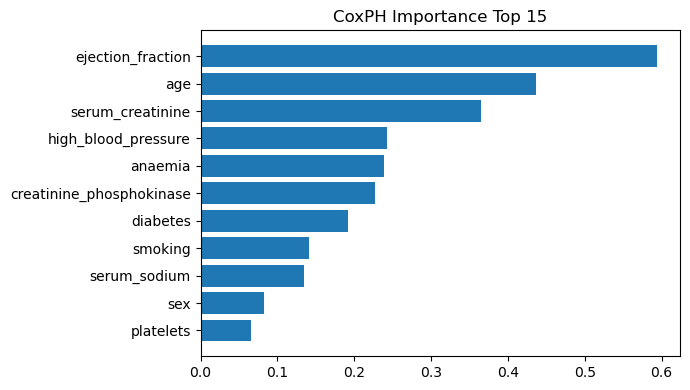

In [109]:
# train_cox: duration/event 포함한 학습 데이터프레임
# (너는 train_cox 만들었었지: features + time + DEATH_EVENT)

features = [c for c in train_cox.columns if c not in ["time", "DEATH_EVENT"]]

X_feat = train_cox[features].copy()
std = X_feat.std().replace(0, 1)

cox_imp = pd.DataFrame({
    "feature": features,
    "coef": cph.params_.loc[features].values,
})
cox_imp["std"] = std.values
cox_imp["std_coef"] = (cox_imp["coef"] * cox_imp["std"]).abs()  # 표준편차 1 증가 시 영향 크기
cox_imp = cox_imp.sort_values("std_coef", ascending=False)

plt.figure(figsize=(7,4))
plt.barh(cox_imp["feature"].head(15)[::-1], cox_imp["std_coef"].head(15)[::-1])
plt.title("CoxPH Importance Top 15")
plt.tight_layout()
plt.show()
